In [1]:
from utils import *
import episcanpy.api as epi
import time
import umap

2024-03-02 13:04:56.691649: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-02 13:04:56.713478: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-02 13:04:57.019544: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Read data

In [2]:
file_path = '../data/E13_5-S1_atac.h5ad'

adata_raw = sc.read_h5ad(file_path)
adata_raw.obs['label'] = adata_raw.obs['Annotation_for_Combined']
print('load data: ', adata_raw)

epi.pp.filter_features(adata_raw, min_cells=1)
epi.pp.filter_cells(adata_raw, min_features=1)
num_all_peak = adata_raw.n_vars
print('data after pre-filtering: ', adata_raw)

load data:  AnnData object with n_obs × n_vars = 1777 × 271126
    obs: 'gex_barcode', 'atac_barcode', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nUMI', 'Gex_nGenes

# Run Descartes

In [3]:
save_path = '../result/mouse_brain'
if not os.path.exists(save_path):
    os.makedirs(save_path)
num_select_peak = 10000
seed_base = 1
tf = 'tfidf2'
pc = 10
k = 20
similarity = 'cosine'
iter_time = 4
spmethod = 'threshold'
neighbor = 5
sp_dist = 'recip'
pre_select = 'highest'
peaks_num = 50000
distance = 'euclidean'
r = 0.4

start_time = time.time()

adata = sc.AnnData(adata_raw.X,dtype = 'float32')
idx, sorted_index, simi_matrix, idx_all, scores, selected_peaks_data,similarity_matrix_acb, similarity_matrix_spatial = run_descartes(adata_raw, num_select_peak, seed_base=seed_base, tfidf=tf, ifPCA=True, pc=pc, k=k, similarity=similarity, iters=iter_time, spmethod=spmethod,neighbor=neighbor,sp_dist=sp_dist, pre_select=pre_select, peaks_num=peaks_num, distance=distance,r=r)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Running time: {elapsed_time:.6f} seconds")

AnnData object with n_obs × n_vars = 1777 × 271126
    obs: 'gex_barcode', 'atac_barcode', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nUMI', 'Gex_nGenes', 'Gex_Mito

# Data imputation

In [4]:
data_enhance = scale(simi_matrix @ selected_peaks_data)
data_enhance.shape

(1777, 10000)

In [5]:
count_filter = PCA(n_components=10,random_state=int(seed_base*1000)).fit_transform(np.array(data_enhance))
adata_pca = sc.AnnData(scipy.sparse.csc_matrix(count_filter),dtype = 'float32')
adata_pca.obs['label'] = list(adata_raw.obs['label'])

sc.pp.neighbors(adata_pca, n_neighbors=15, use_rep='X',random_state=seed_base*1000)
leiden_df = run_leiden(adata_pca,'label','cluster',seed=int(seed_base*1000))

leiden_df

Clustering...
resolution: 0.1, NMI: 0.5507485184060299, ARI: 0.44659636324213475, Homo: 0.543682034803692, AMI: 0.5457635745791729
resolution: 0.2, NMI: 0.5100753542676343, ARI: 0.37033630503382514, Homo: 0.5472594761988047, AMI: 0.5041745055996871
resolution: 0.3, NMI: 0.47128052956078875, ARI: 0.23863804652950626, Homo: 0.5655099602243624, AMI: 0.4624853703635891
resolution: 0.4, NMI: 0.47891242029519915, ARI: 0.20693481377014206, Homo: 0.6136276907280485, AMI: 0.4686721913074149
resolution: 0.5, NMI: 0.474026220429642, ARI: 0.18419454433539767, Homo: 0.6343036778966934, AMI: 0.46213142636849786
resolution: 0.6, NMI: 0.4752297412393157, ARI: 0.17198119895762623, Homo: 0.6563437465489618, AMI: 0.4624242135215891
resolution: 0.7, NMI: 0.48092279982137176, ARI: 0.1679420454015638, Homo: 0.6736187493105751, AMI: 0.4677903649483701
resolution: 0.8, NMI: 0.4794839085532978, ARI: 0.1683126566623197, Homo: 0.6704122575174217, AMI: 0.4663286545421277
resolution: 0.9, NMI: 0.48092279982137165,

,resolution,NMI,ARI,Homo,AMI
0,0.100000,0.550749,0.446596,0.543682,0.545764
1,0.269531,0.493077,0.290038,0.590896,0.484634
2,0.100000,0.550749,0.446596,0.543682,0.545764
3,0.200000,0.510075,0.370336,0.547259,0.504175
4,0.300000,0.471281,0.238638,0.565510,0.462485
5,0.400000,0.478912,0.206935,0.613628,0.468672
6,0.500000,0.474026,0.184195,0.634304,0.462131
7,0.600000,0.475230,0.171981,0.656344,0.462424
8,0.700000,0.480923,0.167942,0.673619,0.467790
9,0.800000,0.479484,0.168313,0.670412,0.466329


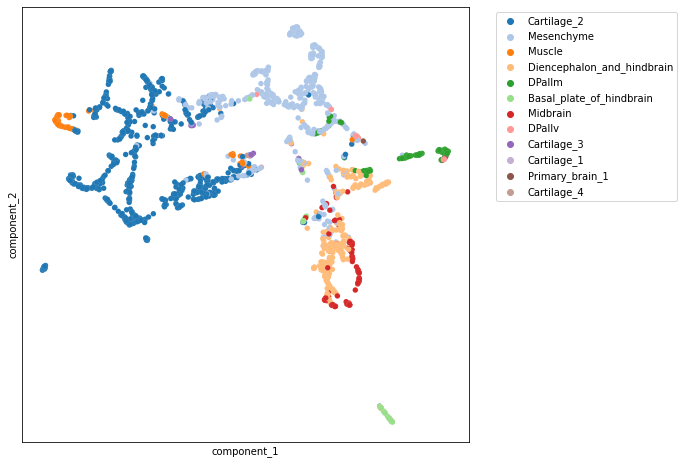

In [6]:
label = adata_pca.obs['label']
proj = umap.UMAP().fit_transform(count_filter)
fig = plt.figure()
fig.set_figwidth(8)
fig.set_figheight(8)
df = {'component_1':proj[:, 0],\
    'component_2':proj[:, 1], \
    'label':label}
df = pd.DataFrame(df)
ax = sns.scatterplot(x="component_1", y="component_2", hue="label",palette = 'tab20', s=30,linewidth = 0.05, data=df)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks([])
plt.yticks([])
plt.show()

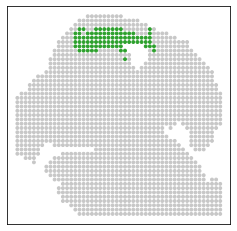

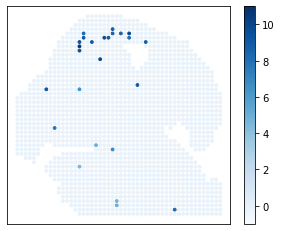

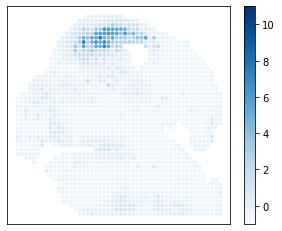

In [7]:
select_domain = np.where(adata_raw.obs['label'] == 'DPallm')[0]
no_select_domain = np.where(adata_raw.obs['label'] != 'DPallm')[0]
label = np.array(adata_raw.obs['label'])
label[select_domain] = '#2ca02c'
label[no_select_domain] = '#c7c7c7'
adata_raw.obs['label_new'] = label

plt.figure(figsize=(4,4))
coord_x = np.array(adata_raw.obsm['spatial'][:,0])
coord_y = -np.array(adata_raw.obsm['spatial'][:,1])
plt.scatter(coord_x, coord_y, s=8, c=label)
plt.xticks([])
plt.yticks([])
plt.show()

plt.figure(figsize=(5,4))
accs = selected_peaks_data[:,6488]
accs = np.array(accs)
accs = np.squeeze(accs)
plt.scatter(coord_x, coord_y, c=accs, s=8, cmap='Blues',vmin=-1,vmax=11)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

plt.figure(figsize=(5,4))
accs = data_enhance[:,6488]
accs = np.array(accs)
accs = np.squeeze(accs)
plt.scatter(coord_x, coord_y, c=accs, s=8, cmap='Blues',vmin=-1,vmax=11)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()